In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings, string
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_csv('Preprocessed Fake Reviews Detection Dataset.csv')

df.head()

,Unnamed: 0,category,rating,label,text_
0,0,Home_and_Kitchen_5,5.0,CG,"love this! well made, sturdy, and veri comfort..."
1,1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrad from the original. i'v..."
2,2,Home_and_Kitchen_5,5.0,CG,thi pillow save my back. i love the look and f...
3,3,Home_and_Kitchen_5,1.0,CG,"miss inform on how to use it, but it is a grea..."
4,4,Home_and_Kitchen_5,5.0,CG,veri nice set. good quality. we have had the s...


In [3]:
df.drop('Unnamed: 0',axis=1,inplace=True)


In [4]:
df.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"love this! well made, sturdy, and veri comfort..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrad from the original. i'v..."
2,Home_and_Kitchen_5,5.0,CG,thi pillow save my back. i love the look and f...
3,Home_and_Kitchen_5,1.0,CG,"miss inform on how to use it, but it is a grea..."
4,Home_and_Kitchen_5,5.0,CG,veri nice set. good quality. we have had the s...


In [5]:
df.dropna(inplace=True)

In [6]:
df.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"love this! well made, sturdy, and veri comfort..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrad from the original. i'v..."
2,Home_and_Kitchen_5,5.0,CG,thi pillow save my back. i love the look and f...
3,Home_and_Kitchen_5,1.0,CG,"miss inform on how to use it, but it is a grea..."
4,Home_and_Kitchen_5,5.0,CG,veri nice set. good quality. we have had the s...


In [7]:
df['length'] = df['text_'].apply(len)


In [8]:
df.head()

,category,rating,label,text_,length
0,Home_and_Kitchen_5,5.0,CG,"love this! well made, sturdy, and veri comfort...",73
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrad from the original. i'v...",75
2,Home_and_Kitchen_5,5.0,CG,thi pillow save my back. i love the look and f...,64
3,Home_and_Kitchen_5,1.0,CG,"miss inform on how to use it, but it is a grea...",72
4,Home_and_Kitchen_5,5.0,CG,veri nice set. good quality. we have had the s...,84


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   category  40432 non-null  object 
 1   rating    40432 non-null  float64
 2   label     40432 non-null  object 
 3   text_     40432 non-null  object 
 4   length    40432 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 1.5+ MB


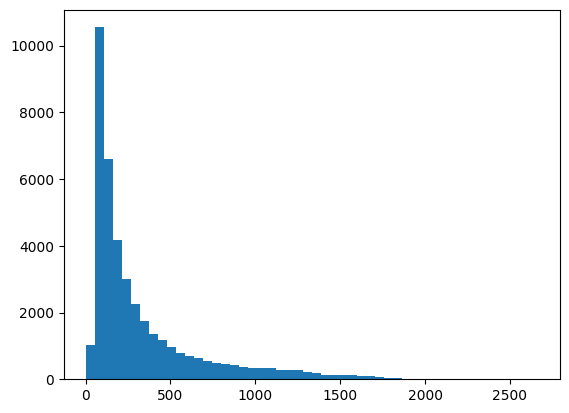

In [10]:
plt.hist(df['length'],bins=50)
plt.show()

In [11]:
df.groupby('label').describe()

rating                                                length  \
         count      mean       std  min  25%  50%  75%  max    count   
label                                                                  
CG     20216.0  4.259893  1.141065  1.0  4.0  5.0  5.0  5.0  20216.0   
OR     20216.0  4.253265  1.147652  1.0  4.0  5.0  5.0  5.0  20216.0   

                                                                  
             mean         std   min    25%    50%    75%     max  
label                                                             
CG     288.749307  289.943288   3.0   90.0  165.0  361.0  1649.0  
OR     370.685002  389.662744  24.0  114.0  210.0  464.0  2660.0

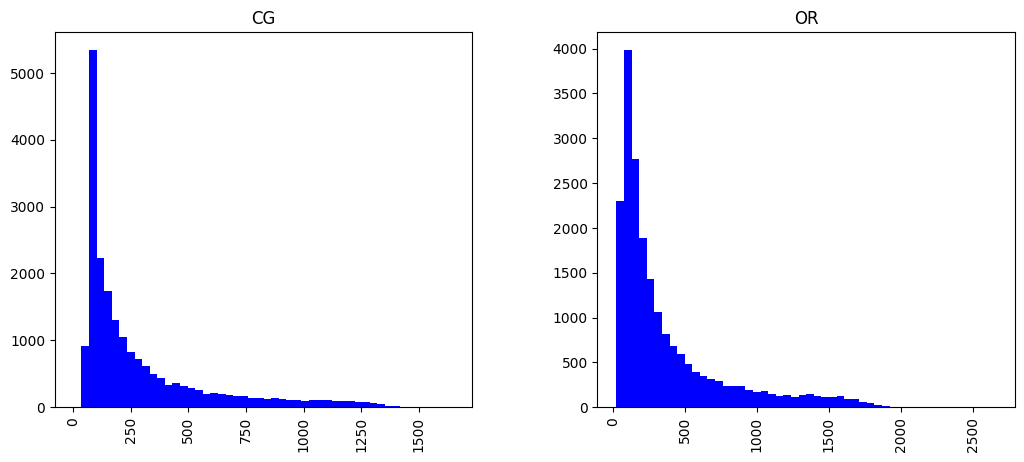

In [12]:
df.hist(column='length',by='label',bins=50,color='blue',figsize=(12,5))
plt.show()

Let's extract the largest review...

In [13]:
df[df['label']=='OR'][['text_','length']].sort_values(by='length',ascending=False).head().iloc[0].text_

'weak on current science. after see it twice, i agre with much (but not all) of the posit five star reviews. out of respect for those who read reviews, i\'ll not repeat everyth that i like about the presentation. i found the goofi over earrings, hairdo, and facial hair arrang of daniel vitalis, (describ a a "wild food expert") distracting. ugh. ditto for david wolfe, who had an extrem goofi wild hairdo. on the other hand, jon gabriel, describ a an "author and weight loss expert" wa nice groom and a good presenter. hi stori of person transform of a fellow of over 400 pound (whew) to becom a jock of normal weight wa inspiring. christian northrup preserv her rank a one of america\' cutest doctors. a realli nice look woman! present by dr. mercola, jason vale, kri carr, alejandro junger were fine. it wa disappoint to have jami oliv (so popular in the uk) give babi cow growth fluid a pas with unscientif but popular idea on milk. none of the present had anyth (zilch) to say about the work of 

In [14]:
df.length.describe()

count    40432.000000
mean       329.717155
std        345.872188
min          3.000000
25%        100.000000
50%        187.000000
75%        411.000000
max       2660.000000
Name: length, dtype: float64

In [15]:
def text_process(review):
    nopunc = [char for char in review if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [16]:
bow_transformer = CountVectorizer(analyzer=text_process)
bow_transformer

CountVectorizer(analyzer=<function text_process at 0x00000265B2952980>)

In [17]:
bow_transformer.fit(df['text_'])
print("Total Vocabulary:",len(bow_transformer.vocabulary_))

Total Vocabulary: 47209


In [18]:
review4 = df['text_'][3]
review4

'miss inform on how to use it, but it is a great product for the price! i'

In [19]:
bow_msg4 = bow_transformer.transform([review4])
print(bow_msg4)
print(bow_msg4.shape)

  (0, 18739)	1
  (0, 21911)	1
  (0, 27266)	1
  (0, 32655)	1
  (0, 32849)	1
  (0, 44279)	1
(1, 47209)


There are 6 unique words in the 4th review.

In [21]:
print(bow_transformer.get_feature_names_out()[15841])
print(bow_transformer.get_feature_names_out()[23848])

faq
koh


In [22]:
bow_reviews = bow_transformer.transform(df['text_'])

In [23]:
df1=pd.read_csv("Preprocessed amazon dataset.csv")
review1_test=df1['text_']

In [24]:
print("Shape of Bag of Words Transformer for the entire reviews corpus:",bow_reviews.shape)
print("Amount of non zero values in the bag of words model:",bow_reviews.nnz)

Shape of Bag of Words Transformer for the entire reviews corpus: (40432, 47209)
Amount of non zero values in the bag of words model: 1117637


In [25]:
print("Sparsity:",np.round((bow_reviews.nnz/(bow_reviews.shape[0]*bow_reviews.shape[1]))*100,2))

Sparsity: 0.06


In [26]:
tfidf_transformer = TfidfTransformer().fit(bow_reviews)
tfidf_rev4 = tfidf_transformer.transform(bow_msg4)
print(bow_msg4)

  (0, 18739)	1
  (0, 21911)	1
  (0, 27266)	1
  (0, 32655)	1
  (0, 32849)	1
  (0, 44279)	1


In [27]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['mango']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['book']])

10.914254381647021
2.848517882189941


In [28]:
tfidf_reviews = tfidf_transformer.transform(bow_reviews)
print("Shape:",tfidf_reviews.shape)
print("No. of Dimensions:",tfidf_reviews.ndim)

Shape: (40432, 47209)
No. of Dimensions: 2


## Creating training and testing data

In [29]:
review_train, review_test, label_train, label_test = train_test_split(df['text_'],df['label'],test_size=0.35)

In [30]:
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
])

logistic regression

In [31]:
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',LogisticRegression())
])

In [32]:
df1=pd.read_csv("Preprocessed amazon dataset.csv")
review1_test=df1['text_']

In [33]:
pipeline.fit(review_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x00000265B2952980>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', LogisticRegression())])

In [34]:
lr_pred = pipeline.predict(review_test)
lr_pred

array(['OR', 'OR', 'OR', ..., 'OR', 'CG', 'OR'], dtype=object)

In [48]:
df1=pd.read_csv("E:/7th sem/Final year project/application/frisapp/Preprocessed amazon dataset.csv")
review1_test=df1['text_']

In [49]:
alrpred=pipeline.predict(review1_test)
alrpred

array(['OR', 'OR', 'OR', 'CG', 'OR', 'OR', 'OR', 'CG', 'OR', 'OR'],
      dtype=object)

In [41]:
import pandas as pd
import chart_studio as cs
import chart_studio.plotly as py
import chart_studio.tools as tls
import plotly.express as px

In [50]:
username='adithyan_p_s'
apikey='xVafosyUZAARgR5ZaVsY'
cs.tools.set_credentials_file(username=username,api_key=apikey)

In [52]:
OR=0
CG=0
for i in alrpred:
    if i=='OR':
        OR=OR+1
    else:
        CG=CG+1
lst=[CG,OR]
lst

[2, 8]

In [53]:

fig = px.bar(x=['CG','OR'], y=lst)
fig.write_html('first_figure.html', auto_open=True)
py.plot(fig)

'https://plotly.com/~adithyan_p_s/17/'

In [36]:
print('Classification Report:',classification_report(label_test,lr_pred))
print('Confusion Matrix:',confusion_matrix(label_test,lr_pred))
print('Accuracy Score:',accuracy_score(label_test,lr_pred))
print('Model Prediction Accuracy:',str(np.round(accuracy_score(label_test,lr_pred)*100,2)) + '%')

Classification Report:               precision    recall  f1-score   support

          CG       0.87      0.85      0.86      7012
          OR       0.86      0.88      0.87      7140

    accuracy                           0.87     14152
   macro avg       0.87      0.87      0.87     14152
weighted avg       0.87      0.87      0.87     14152

Confusion Matrix: [[5978 1034]
 [ 858 6282]]
Accuracy Score: 0.8663086489542114
Model Prediction Accuracy: 86.63%
